In [50]:
import pandas as pd
import numpy as np
from keras.layers import SimpleRNN, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [2]:
data = pd.read_csv('IMDB Dataset.csv')
data['review'] = data['review'].str.lower()


In [3]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]


In [4]:
def remove_stopwords(data):
    data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in str(x).split() if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

In [5]:
data_without_stopwords = remove_stopwords(data)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')


In [6]:
data_without_stopwords.head()

,review,sentiment,review without stopwords,clean_review
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching just 1 oz epi...,one reviewers mentioned watching just 1 oz epi...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zomb...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...",petter mattei s love time money visually stu...


In [7]:
reviews = data_without_stopwords['clean_review']
reviews

0        one reviewers mentioned watching just 1 oz epi...
1        wonderful little production  the filming techn...
2        thought wonderful way spend time hot summer we...
3        basically family little boy  jake  thinks zomb...
4        petter mattei s  love time money  visually stu...
                               ...                        
49995    thought movie right good job  wasn t creative ...
49996    bad plot  bad dialogue  bad acting  idiotic di...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    no one expects star trek movies high art  fans...
Name: clean_review, Length: 50000, dtype: object

In [9]:
reviews_list = []
for i in range(len(reviews)):
    reviews_list.append(reviews[i])
sentiment = data_without_stopwords['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiment)))
y

array([1, 1, 1, ..., 0, 0, 0])

In [27]:
X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.3, random_state = 45)
len(X_train)


35000

In [28]:
tokenizer =Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index
vocab_len=len(words_to_index)
maxLen=150
len(words_to_index)


89997

In [29]:
def imdb_rating(input_shape):

    X_indices = Input(input_shape)

    embeddings= Embedding(input_dim=vocab_len, output_dim=50, input_length=maxLen)(X_indices) 
    
    X = SimpleRNN(150, return_sequences=True)(embeddings)
     
    X = Dropout(0.3)(X)

    X = SimpleRNN(100, return_sequences=True)(X)
    
    X = Dropout(0.3)(X)

    X = SimpleRNN(50)(X)

    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=X_indices, outputs=X)

    return model




In [30]:
model = imdb_rating((maxLen,))
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 50)           4499850   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 150, 150)          30150     
                                                                 
 dropout_4 (Dropout)         (None, 150, 150)          0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 150, 100)          25100     
                                                                 
 dropout_5 (Dropout)         (None, 150, 100)          0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 50)                7550

In [31]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape


(35000, 150)

In [32]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#print(history.history.keys())
#['accuracy', 'loss', 'val_accuracy', 'val_loss']


In [33]:
history=model.fit(X_train_indices, Y_train, batch_size=56, epochs=15)


Epoch 1/15
625/625 [==============================] - 115s 181ms/step - loss: 0.7068 - accuracy: 0.5019
Epoch 2/15
625/625 [==============================] - 107s 171ms/step - loss: 0.6964 - accuracy: 0.5033
Epoch 3/15
625/625 [==============================] - 109s 175ms/step - loss: 0.6930 - accuracy: 0.5169
Epoch 4/15
625/625 [==============================] - 111s 177ms/step - loss: 0.6882 - accuracy: 0.5307
Epoch 5/15
625/625 [==============================] - 114s 182ms/step - loss: 0.6706 - accuracy: 0.5640 - loss:
Epoch 6/15
625/625 [==============================] - 109s 175ms/step - loss: 0.5874 - accuracy: 0.6535
Epoch 7/15
625/625 [==============================] - 107s 171ms/step - loss: 0.3058 - accuracy: 0.8792 - loss: 0.3
Epoch 8/15
625/625 [==============================] - 114s 182ms/step - loss: 0.2160 - accuracy: 0.9194
Epoch 9/15
625/625 [==============================] - 113s 181ms/step - loss: 0.1688 - accuracy: 0.9394
Epoch 10/15
625/625 [=======================

In [34]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
history_1 = model.evaluate(X_test_indices, Y_test)


469/469 [==============================] - 11s 24ms/step - loss: 0.6573 - accuracy: 0.8524


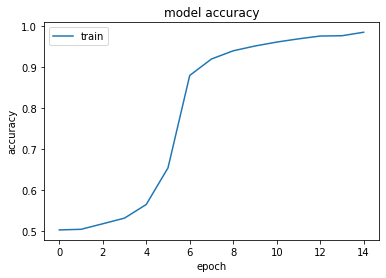

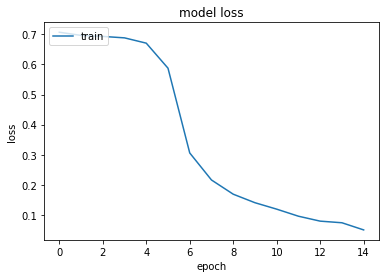

In [36]:
#['accuracy', 'loss', 'val_accuracy', 'val_loss']
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




In [37]:
reviews_list_idx = tokenizer.texts_to_sequences(reviews_list)
pred_sentiment=[]
def add_score_predictions(data, reviews_list_idx):

    data['sentiment score'] = 0

    reviews_list_idx = pad_sequences(reviews_list_idx, maxlen=maxLen, padding='post')

    review_preds = model.predict(reviews_list_idx)

    data['sentiment score'] = review_preds

    pred_sentiment = np.array(list(map(lambda x : 'positive' if x > 0.5 else 'negative',review_preds)))

    data['predicted sentiment'] = 0

    data['predicted sentiment'] = pred_sentiment

    return data

  
data = add_score_predictions(data, reviews_list_idx)
data

,review,sentiment,review without stopwords,clean_review,sentiment score,predicted sentiment
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching just 1 oz epi...,one reviewers mentioned watching just 1 oz epi...,0.037216,negative
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...,0.998808,positive
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...,0.971712,positive
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zomb...,0.000503,negative
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...",petter mattei s love time money visually stu...,0.999237,positive
...,...,...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,thought movie right good job. wasn't creative ...,thought movie right good job wasn t creative ...,0.982105,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogue bad acting idiotic di...,0.001648,negative
49997,i am a catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...,catholic taught parochial elementary schools n...,0.000961,negative
49998,i'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...,going disagree previous comment side maltin on...,0.001229,negative


In [52]:
preds=model.predict(X_test_indices)
pred_senti = np.array(list(map(lambda x : 1 if x > 0.5 else 0,preds)))
confusion_matrix(Y_test,pred_senti)

array([[6147, 1347],
       [ 867, 6639]], dtype=int64)

In [53]:
accuracy_score(Y_test,pred_senti, normalize=True)

0.8524

In [54]:
precision_recall_fscore_support(Y_test,pred_senti,average='binary')

(0.8313298271975957, 0.8844924060751399, 0.8570875290472502, None)